# Multi-scale analysis
## SFtools-bigdata hands-on workshop

This notebook presents a non-exhaustive review of the python tools available to the astrophysical community to perform multi-scale and related analysis.

The demonstrations are based on mainly two packages:

 - Pywavan - [https://github.com/jfrob27/pywavan](https://github.com/jfrob27/pywavan)
 - TurbuStat - [https://github.com/Astroua/TurbuStat](https://github.com/Astroua/TurbuStat)
 
*Pywavan* has been developed by me and it revolves mainly around one function which is dedicated to the wavelet power spectrum analysis of a map and its **Multi-scale non-Gaussian Segmentation (MnGSeg)**. It also contains functions to perform the **classical Fourier power spectrum analysis**, generate **fractal simulations** and do basic data manipulation, such as **cutting fits maps**, **beam convolution**.

*TurbuStat* aimes at facilitating comparisons between spectral line data cubes. Included in this package are several techniques described in the literature which aim to describe some property of a data cube. It also includes an impressive collection of statistical analysis techniques, such as the **PDF**, the **power spectrum**, the **∆-variance**, the **dendrogram**, etc.

## Why multi-scale analysis techniques?

The structure formation in the interstellar medium is largely dominated by mutli-scale processes such as turbulence through its energy cascade and gravity, which is responsible for the formation of the densest structures.

Measuring the scaling behaviour of a cloud and decomposing its building blocks using several statistical techniques can help us to understand the physical mecanisms at the origin of cloud structure formation and ultimately the formation of stars.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Download data

In [3]:
import wget

In [4]:
url = "http://www.herschel.fr/Phocea/file.php?class=astimg&file=66/taurus_L1495_250.fits.gz"
wget.download(url, './taurus_L1495_250.fits')

'./taurus_L1495_250 (1).fits'

Open data

In [2]:
from astropy.io import fits
import aplpy

In [18]:
HDU = fits.open('./polaris-250_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -1.740e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.369e+01 [aplpy.core]


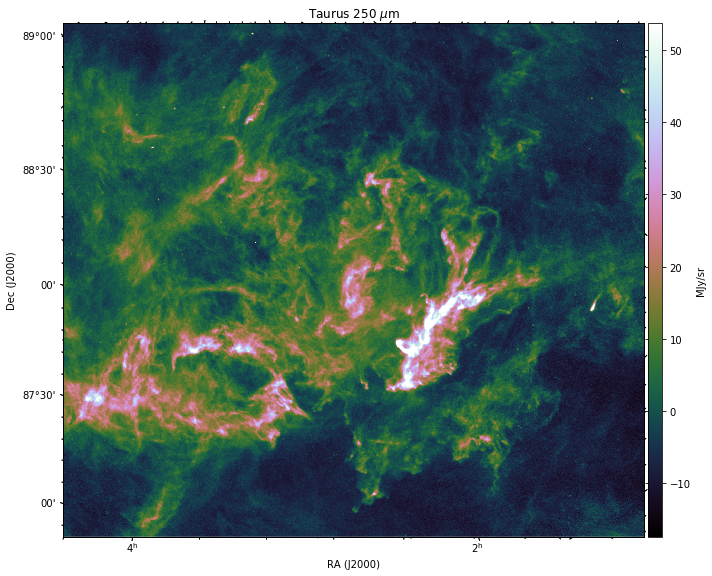

In [7]:
fig_all = plt.figure(1, figsize=(10,10))

fig = aplpy.FITSFigure(fits.PrimaryHDU(im,header=header),figure=fig_all)
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(header['BUNIT'])
fig.set_title("Taurus 250 $\mu$m")
plt.tight_layout()

Rotate & cut the map

# Dendrograms

In general, dendrograms provide a hierarchical description of datasets, which may be used to identify clusters of similar objects or variables. This is known as hierarchical clustering. In the case of position-position-velocity (PPV) cubes, a dendrogram is a hierarchical decomposition of the emission in the cube. This decomposition was introduced by [Rosolowsky et al. 2008](https://ui.adsabs.harvard.edu/#abs/2008ApJ...679.1338R/abstract) and [Goodman et al. 2009](https://ui.adsabs.harvard.edu/#abs/2009Natur.457...63G/abstract) to calculate the multiscale properties of molecular gas in nearby clouds. The tree structure is comprised of branches and leaves. Branches are the connections, while leaves are the tips of the branches.

In [52]:
from turbustat.statistics import Dendrogram_Stats
from astrodendro import Dendrogram
import astropy.units as u

In [91]:
d = Dendrogram.compute(im, min_value=0.0, min_delta=10.0, min_npix=50, verbose=False)

Text(0.5, 0, 'Structure')

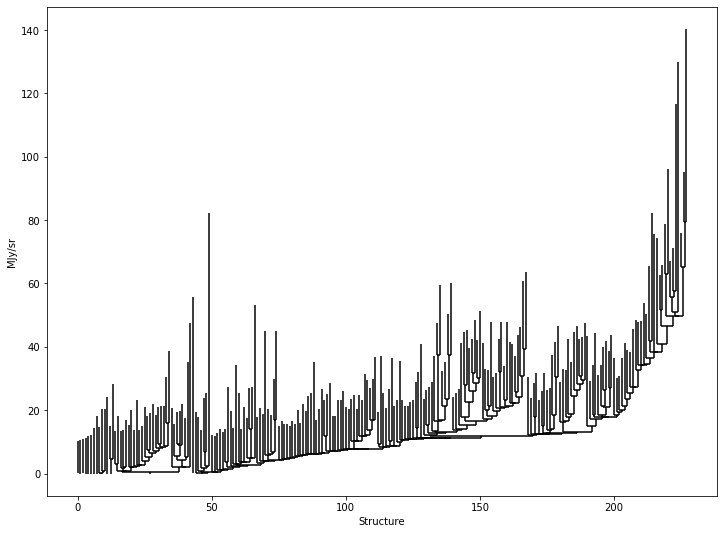

In [92]:
figure(figsize=(12,9))
ax = subplot(111)  
p = d.plotter()
p.plot_tree(ax, color='black')
#p.plot_tree(ax, structure=5, color='yellow', lw=2, alpha=0.5)
#p.plot_tree(ax, structure=10, color='red', lw=2, alpha=0.5)
#p.plot_tree(ax, structure=20, color='blue', lw=2, alpha=0.5)
ylabel(header['BUNIT'])
xlabel('Structure')

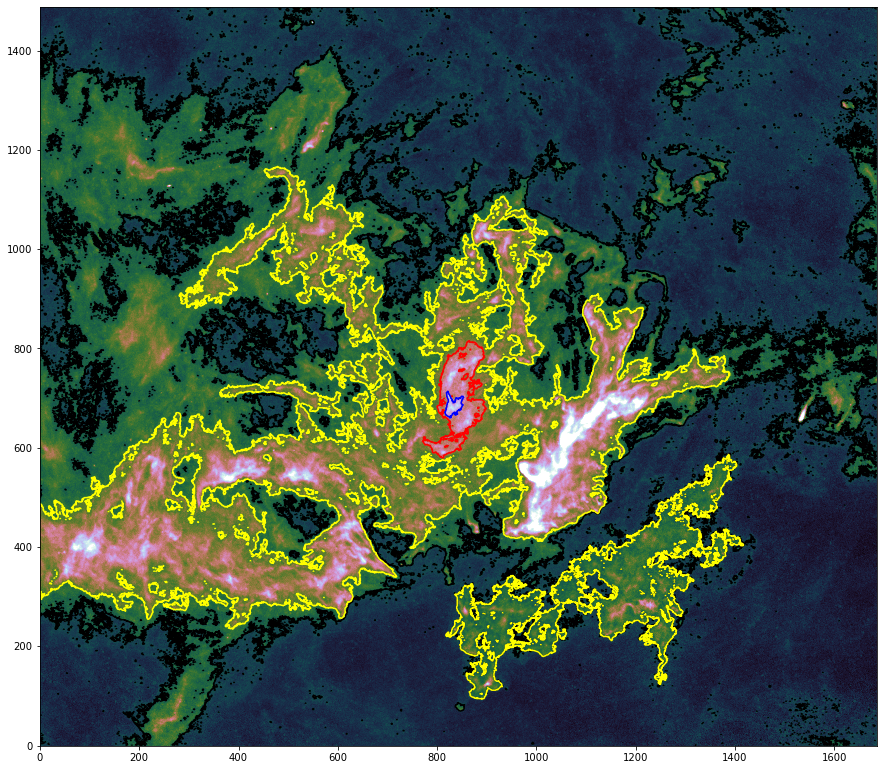

In [95]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im, origin='lower', interpolation='nearest', cmap='cubehelix',vmin=-1.774e+01, vmax=5.339e+01)

# Show contour for ``min_value``
p.plot_contour(ax, colors='black')

# Highlight branches
p.plot_contour(ax, structure=12, lw=3, colors='yellow')
p.plot_contour(ax, structure=107, lw=3, colors='yellow')
p.plot_contour(ax, structure=261, lw=3, colors='red')
p.plot_contour(ax, structure=291, lw=3, colors='blue')

Branches selected using the Interactive Visualization of *astrodendro*. See instruction [here](https://dendrograms.readthedocs.io/en/stable/plotting.html).

In [99]:
dend_stat = Dendrogram_Stats(im,header=header,
...                              min_deltas=np.logspace(1, 10, 25),
...                              dendro_params={"min_value": 0.0, "min_npix": 50})

In [107]:
#dend_stat.run()

# Power spectrum

A power spectrum measure the amount of power (squared amplitude of spatial fluctuations) as a function of spatial frequencies. The most common way to estimate the power spectrum is to average the squared amplitude as a function of scales over the azimuthal directions in the Fourier space.

Fourier transform of an image:
$$\hat{f}(\vec{k}) = \int^{\infty}_{-\infty} f(\vec{x}) e^{-2\pi i\vec{x} \cdot \vec{k}}d\vec{k}$$

Fourier power spectrum estimation:
$$P(k) = \langle |\hat{f}(\vec{k})|^2 \rangle_{\theta}$$

## Fractional Brownian motion (fBm)

An fBm simulation is a simple way to generate random Gaussian fluctuations as a function of scales. These mock objects mimic ''part'' of the fractal behavior of interstellar medium and can be used to excute simple tests on statistical tools (as the power spectrum).

They are generated by calculating the inverse Fourier transform of random complex-number noise in the Fourier space multiplied by a power law"

In [20]:
from pywavan import fbm2d
from turbustat.simulator import make_extended

Text(0.5, 1.0, 'Turbustat')

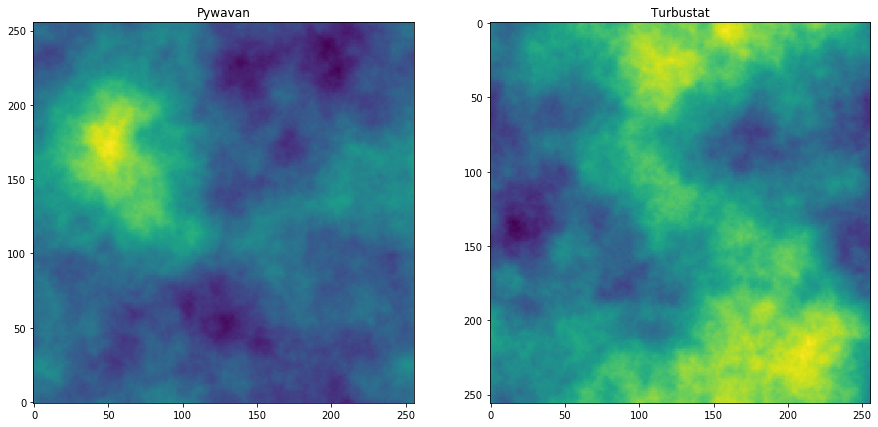

In [21]:
#Pywavan
fbm = fbm2d(-3.6,256,256)

#Turbustat
fbmturbu = make_extended(256, powerlaw=3.6)

figure(figsize=(15,10))
subplot(1,2,1)
imshow(fbm, origin='lower')
title('Pywavan')
subplot(1,2,2)
imshow(fbmturbu)
title('Turbustat')

## Fourier Power Spectrum analysis

In [11]:
from pywavan import powspec

In [29]:
tab_k, spec_k = powspec(fbm, reso = 1)
tab_k, spec_kturbu = powspec(fbmturbu, reso = 1)

#Pywavan fBm Power spectrum fit
A = np.polyfit(np.log(tab_k), np.log(spec_k),deg=1)
fit = np.exp(A[1])*tab_k**A[0]
print('Pywavan fBm Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])

#Turbustat fBm Power spectrum fit
A = np.polyfit(np.log(tab_k), np.log(spec_kturbu),deg=1)
fit_turbu = np.exp(A[1])*tab_k**A[0]
print('Turbustat fBm Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])

Pywavan fBm Power fit
A, Gamma =  2.155910808422877e-05 -3.571665095333762
Turbustat fBm Power fit
A, Gamma =  0.003069728899237411 -3.5716650953337625


Text(0.5, 1.0, 'Turbustat')

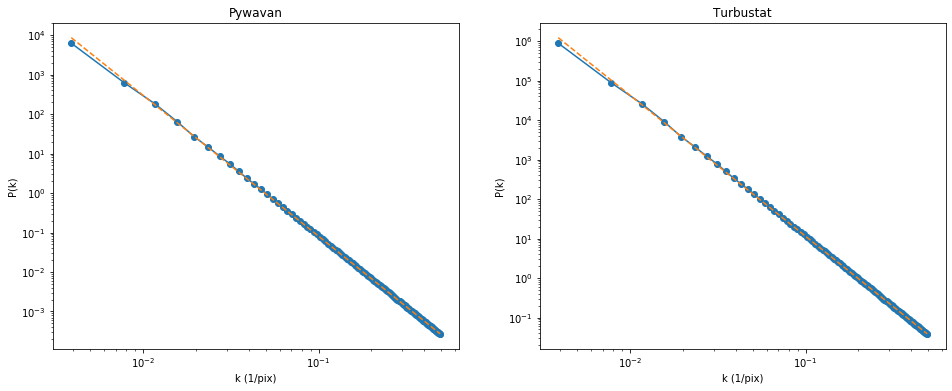

In [30]:
figure(figsize=(16,6))
subplot(1,2,1)
plot(tab_k, spec_k, marker='o')
plot(tab_k, fit, linestyle = '--')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Pywavan')

subplot(1,2,2)
plot(tab_k, spec_kturbu, marker='o')
plot(tab_k, fit_turbu, linestyle = '--')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Turbustat')

In [16]:
from turbustat.statistics import PowerSpectrum

/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/Users/robitaij/anaconda2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/base_pspec2.py:421: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.231e+05
Date:                Mon, 19 Oct 2020   Prob (F-statistic):          2.01e-293
Time:                        10:53:32   Log-Likelihood:                 577.22
No. Observations:                 181   AIC:                            -1150.
Df Residuals:                     179   BIC:                            -1144.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1408      0.004     37.553      0.0

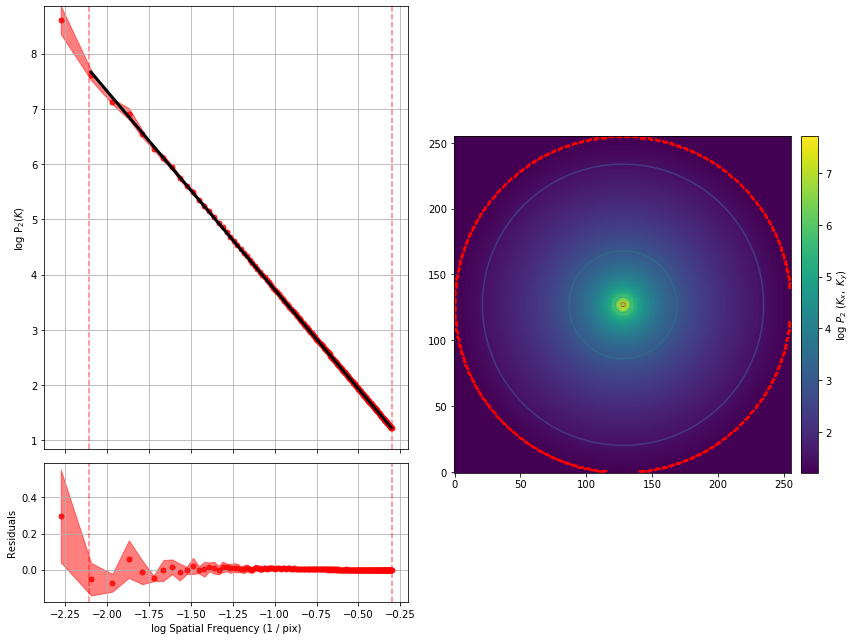

In [37]:
figure(figsize=(12,9))
pspec = PowerSpectrum(fits.PrimaryHDU(fbm))
pspec.run(verbose=True, xunit=u.pix**-1, use_wavenumber=False)

## Fourier power spectrum analysis on Polaris

The Fourier power spectrum of the Polaris flare region has been analysed several times ([Miville-Deschênes et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...518L.104M/abstract), [Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...628A..33R/abstract)) and it is particularly interesting for its apparent scale-free property.

In [8]:
from pywavan import apodize, padding, gauss_beam

In [26]:
#Resolution in arcmin
reso = header['CDELT2'] * 60.

#Apodization
imzm = im - np.mean(im)
tapper = apodize(im.shape[0],im.shape[1],0.98)
imt = imzm *tapper
imr = padding(imt,1800,1800)

#Fourier Powre Spectrum
tab_k_im, spec_k_im = powspec(imr, reso = reso)

In [39]:
#Noise evaluation
noise = np.mean(spec_k_im[(tab_k_im > 3.) & (tab_k_im < 5.)])

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
header['BMAJ'] = 18.2 / 60.
header['BMIN'] = 18.2 / 60.
header['BPA'] = 0.
beam = gauss_beam(FWHM,1800,1800,FWHM=True)
tab_k_im, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

In [48]:
#Power spectrum fit
limites = np.where((tab_k_im >= tab_k_im[1]) & (tab_k_im < 1.0))

A = np.polyfit(np.log(tab_k_im[limites]), np.log((spec_k_im[limites]-noise)/spec_beamn[limites]),deg=1)
fit_im = np.exp(A[1])*tab_k_im**A[0]
print('Pywavan fBm Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])

Pywavan fBm Power fit
A, Gamma =  26.56609256131488 -2.6854778713557246


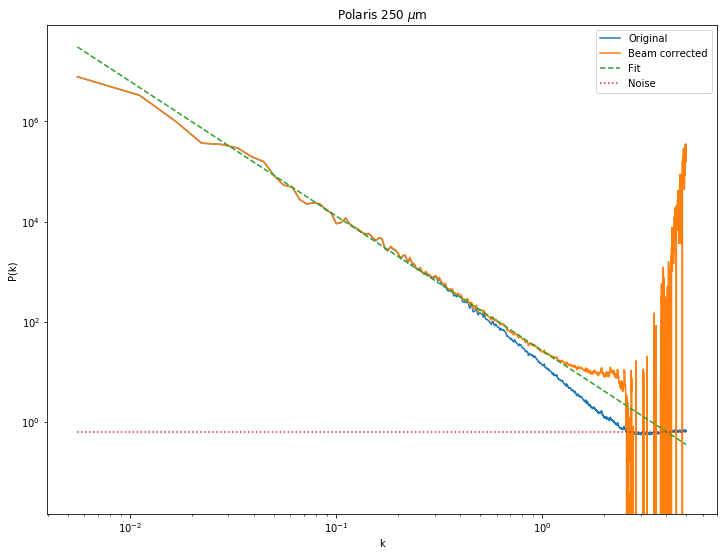

In [49]:
figure(figsize=(12,9))
plot(tab_k_im, spec_k_im, label='Original')
plot(tab_k_im, (spec_k_im-noise)/spec_beamn, label='Beam corrected')
plot(tab_k_im, fit_im, linestyle='--', label='Fit')
plot([tab_k_im[0],tab_k_im[-1]], [noise,noise], linestyle=':', label='Noise')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Polaris 250 $\mu$m')
legend()

/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:166: RuntimeWarning: invalid value encountered in subtract
  stderrs = 0.5 * (percentiles[1] - percentiles[0])
/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/base_pspec2.py:421: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.959e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:11:23   Log-Likelihood:                 34.443
No. Observations:                1124   AIC:                            -64.89
Df Residuals:                    1122   BIC:                            -54.84
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1169      0.016    313.725      0.0

/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


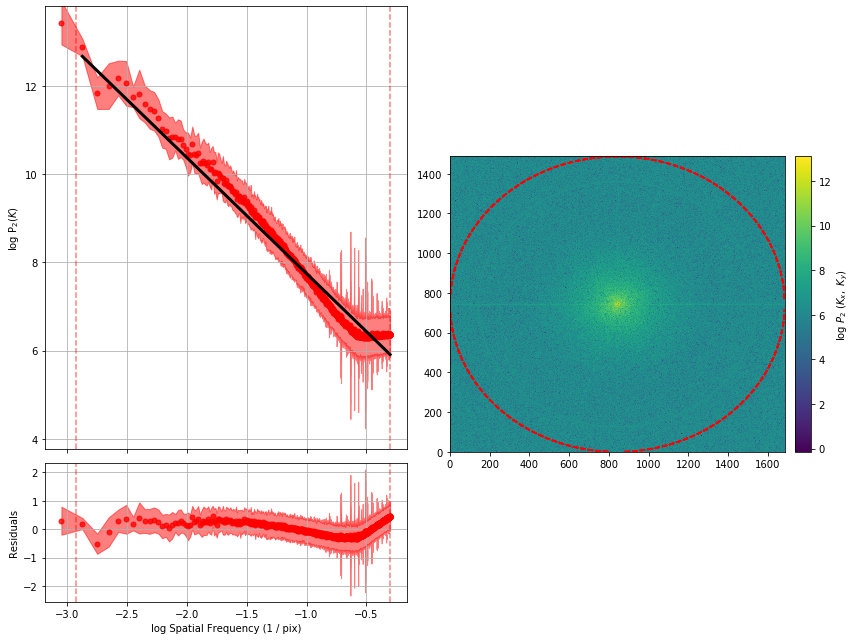

In [55]:
figure(figsize=(12,9))
pspec = PowerSpectrum(im,header)
pspec.run(verbose=True, use_wavenumber=False, fit_2D_kwargs={'fix_ellip_params':True})
#pspec.run(verbose=True, use_wavenumber=False, low_cut=0.0031 / u.pix, high_cut=1. / u.pix,
#          apodize_kernel='tukey', beam_correct=True)

## Probability density distribution (PDF)

Properties of the PDF, when related to an analytical form, have been found to correlate with changes in the turbulent properties (e.g., [Kowal et al. 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...658..423K/abstract), [Federrath et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...512A..81F/abstract)) and gravity (e.g., [Burkhart et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...48B/abstract), [Burkhart et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...834L...1B/abstract)).

In [56]:
from turbustat.statistics import PDF

Optimization terminated successfully.
         Current function value: 0.506870
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -1489.2
Model:                     Likelihood   AIC:                             2984.
Method:            Maximum Likelihood   BIC:                             3002.
Date:                Mon, 19 Oct 2020                                         
Time:                        15:21:49                                         
No. Observations:                2938                                         
Df Residuals:                    2936                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

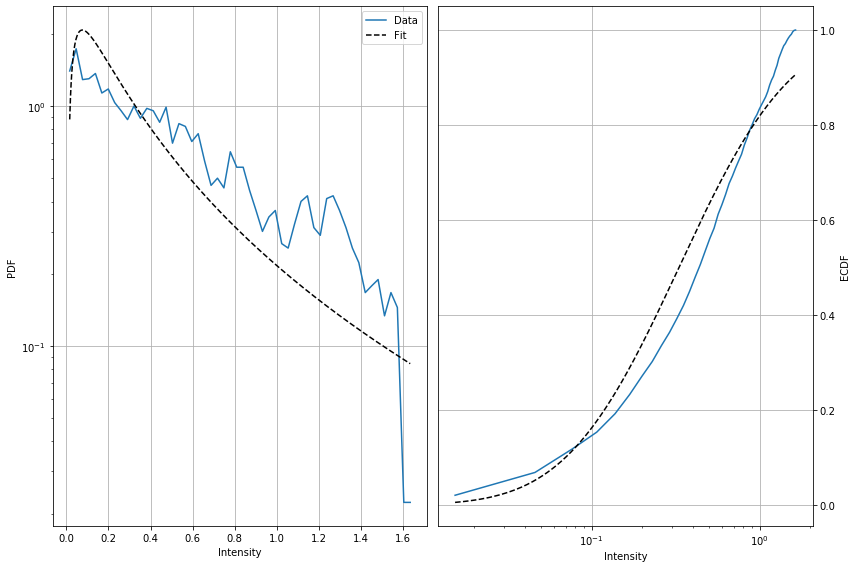

In [66]:
figure(figsize = (12,8))
pdf_fbm = PDF(fbm+np.min(fbm), min_val=0.0, bins=None)  
pdf_fbm.run(verbose=True)

Optimization terminated successfully.
         Current function value: 1.089979
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -1.2699e+06
Model:                     Likelihood   AIC:                         2.540e+06
Method:            Maximum Likelihood   BIC:                         2.540e+06
Date:                Mon, 19 Oct 2020                                         
Time:                        15:43:07                                         
No. Observations:             1165088                                         
Df Residuals:                 1165086                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

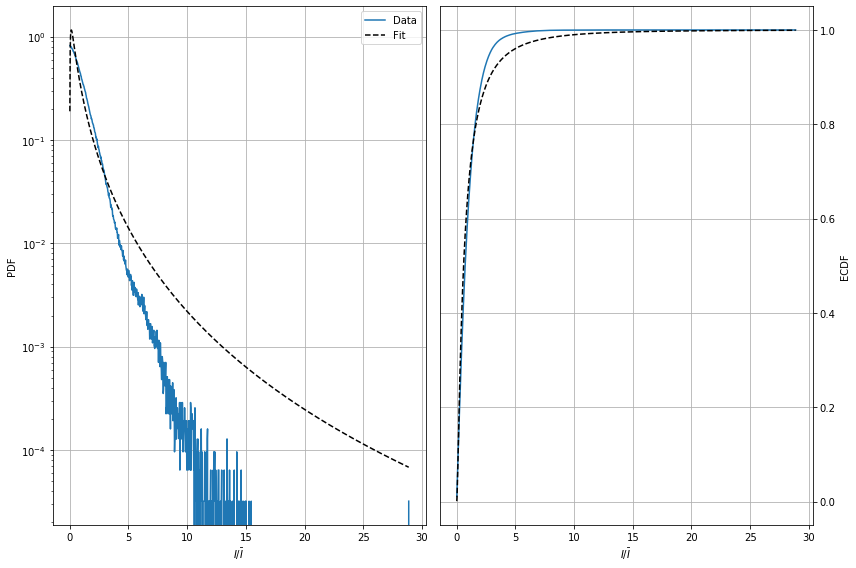

In [79]:
figure(figsize = (12,8))
pdf_fbm = PDF(im, min_val=0.0, bins=None, normalization_type='normalize_by_mean')  
pdf_fbm.run(verbose=True)